In [20]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import  transforms
import torchvision
from PIL import Image

import os
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir = "data/img_align_celeba"

len(os.listdir(data_dir))

202599

In [9]:
set([i[i.index('.'):] for i in os.listdir(data_dir)])

{'.jpg'}

In [5]:
img_transforms = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

img_transforms

Compose(
    Resize(size=64, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(64, 64))
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)

In [21]:
class CelebImages(Dataset):
    def __init__(self, root_dir, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms

        self.image_path = [os.path.join(root_dir, img) for img in os.listdir(self.root_dir) if img.endswith(".jpg")]

    def __len__(self):
        return len(self.image_path)

    def __getitem__(self, index):
        img = self.image_path[index]
        img = Image.open(img)
        if self.transforms:
            img = self.transforms(img)
        return img

In [22]:
celebs = CelebImages(root_dir=data_dir, transforms=img_transforms)

In [24]:
len(celebs), celebs[9].shape

(202599, torch.Size([3, 64, 64]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..1.0].


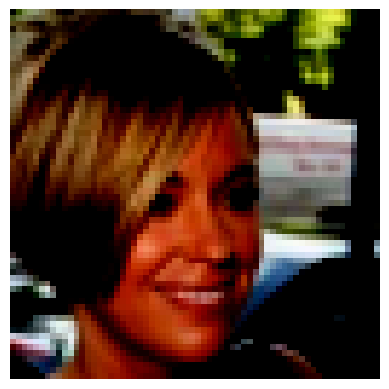

In [31]:
plt.imshow(celebs[0].permute(1, 2, 0))
plt.axis(False)
plt.show()

In [32]:
loader = DataLoader(dataset=celebs, batch_size=128, shuffle=True)
loader

In [36]:
X0 = next(iter(loader))
X0.shape, len(loader)

(torch.Size([128, 3, 64, 64]), 1583)

**Now our dataset is ready, let's build a good Convolutional GAN**

In [37]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

# Model Building

In [145]:
class GeneratorNN(nn.Module):
    def __init__(self, z_dim, num_channeles):
        super().__init__()
        self.noise_layer = nn.Sequential(
            nn.Linear(in_features=z_dim, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=2048),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=8192),
            nn.ReLU()
        )

        self.generator_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=num_channeles, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.noise_layer(z)
        x = x.view(x.shape[0], 128, 8, 8)
        return self.generator_conv(x)
    
Generator = GeneratorNN(z_dim=100, num_channeles=3)
Generator.to(device=device)

Generator

GeneratorNN(
  (noise_layer): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=8192, bias=True)
    (5): ReLU()
  )
  (generator_conv): Sequential(
    (0): ConvTranspose2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Tanh()
  )
)

In [154]:
from torchinfo import summary

summary(model=Generator, input_size=(128, 100), col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
GeneratorNN                              [128, 100]                [128, 3, 64, 64]          --                        True
├─Sequential: 1-1                        [128, 100]                [128, 8192]               --                        True
│    └─Linear: 2-1                       [128, 100]                [128, 512]                51,712                    True
│    └─ReLU: 2-2                         [128, 512]                [128, 512]                --                        --
│    └─Linear: 2-3                       [128, 512]                [128, 2048]               1,050,624                 True
│    └─ReLU: 2-4                         [128, 2048]               [128, 2048]               --                        --
│    └─Linear: 2-5                       [128, 2048]               [128, 8192]               16,785,408                True
│    └─

In [150]:
z = torch.randn(size=(128, 100))
Generator(z).shape

torch.Size([128, 3, 64, 64])

In [ ]:
class DiscrimiatorNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.discriminator_nn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=8192, out_features=2048),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Linear(in_features=2048, out_features=64),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Linear(in_features=64, out_features=1),
            # nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.discriminator_nn(x)
        return self.classifier(x)
    
Discrimiator = DiscrimiatorNN()
Discrimiator.to(device=device)

Discrimiator

DiscrimiatorNN(
  (discriminator_nn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=2048, bias=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=2048, out_features=64, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5

In [152]:
from torchinfo import summary

summary(model=Discrimiator, input_size=(128, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
DiscrimiatorNN                           [128, 1]                  --
├─Sequential: 1-1                        [128, 128, 8, 8]          --
│    └─Conv2d: 2-1                       [128, 64, 64, 64]         1,792
│    └─LeakyReLU: 2-2                    [128, 64, 64, 64]         --
│    └─MaxPool2d: 2-3                    [128, 64, 32, 32]         --
│    └─Conv2d: 2-4                       [128, 128, 32, 32]        73,856
│    └─LeakyReLU: 2-5                    [128, 128, 32, 32]        --
│    └─MaxPool2d: 2-6                    [128, 128, 16, 16]        --
│    └─Conv2d: 2-7                       [128, 128, 16, 16]        147,584
│    └─LeakyReLU: 2-8                    [128, 128, 16, 16]        --
│    └─MaxPool2d: 2-9                    [128, 128, 8, 8]          --
├─Sequential: 1-2                        [128, 1]                  --
│    └─Flatten: 2-10                     [128, 8192]               --
│  

In [144]:
Discrimiator(torch.randn(size=(128, 3, 64, 64))).shape

torch.Size([128, 1])

In [155]:
Generator, Discrimiator

(GeneratorNN(
   (noise_layer): Sequential(
     (0): Linear(in_features=100, out_features=512, bias=True)
     (1): ReLU()
     (2): Linear(in_features=512, out_features=2048, bias=True)
     (3): ReLU()
     (4): Linear(in_features=2048, out_features=8192, bias=True)
     (5): ReLU()
   )
   (generator_conv): Sequential(
     (0): ConvTranspose2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
     (1): ReLU()
     (2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
     (3): ReLU()
     (4): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
     (5): ReLU()
     (6): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (7): Tanh()
   )
 ),
 DiscrimiatorNN(
   (discriminator_nn): Sequential(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): LeakyReLU(negative_slope=0.2, inplace=True)
     (2): Max

In [156]:
gan_loss = nn.BCEWithLogitsLoss()

generator_optimizer = torch.optim.Adam(params=Generator.parameters(), lr=1e-3)
discriminator_optimizer = torch.optim.Adam(params=Discrimiator.parameters(), lr=1e-3)

gan_loss, generator_optimizer, discriminator_optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [158]:
import numpy as np

In [161]:
epochs = 10

Generator = Generator.to(device=device)
Discrimiator = Discrimiator.to(device=device)
for epoch in range(epochs):
    for batch, X in enumerate(loader):
        batch_size = X.shape[0]
        X = X.to(device=device)
        
        reals = torch.ones(size=(batch_size, 1)).to(device=device)
        fakes = torch.zeros(size=(batch_size, 1)).to(device=device)

        # Train discriminators
        Discrimiator.train()
        real_loss = gan_loss(Discrimiator(X), reals)
        fake_loss = gan_loss(Discrimiator(Generator(torch.randn(size=(batch_size, 100)).to(device=device).detach())), fakes)
        disc_loss = (real_loss + fake_loss) / 2
        disc_loss.backward()
        discriminator_optimizer.step()
        discriminator_optimizer.zero_grad()
        
        # Train generators
        Generator.train()
        gen_loss = gan_loss(Discrimiator(Generator((torch.randn(size=(batch_size, 100)).to(device=device).detach()))), reals)
        gen_loss.backward()
        generator_optimizer.step()
        generator_optimizer.zero_grad()

        if batch%200==0:
            print(f"Batch: {batch}, D loss: {disc_loss}, G loss: {gen_loss}")

    z = torch.randn(size=(36, 100)).to(device=device)
    epoch_res = Generator(z).cpu().detach()
    grid = torchvision.utils.make_grid(epoch_res, nrow=4, normalize=True)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title(f"Result after epoch {epoch}")
    plt.axis(False)
    plt.show()


Batch: 0, D loss: 0.7217370271682739, G loss: 0.44871920347213745
Batch: 200, D loss: 0.8132616281509399, G loss: 0.31326165795326233
Batch: 400, D loss: 0.8132616281509399, G loss: 0.31326165795326233
Batch: 600, D loss: 0.8132616281509399, G loss: 0.31326165795326233


KeyboardInterrupt: 